In [1]:
from prawn_predictor import DataProcessor
from fbprophet import Prophet
import numpy as np

In [2]:
model = Prophet(holidays_prior_scale=1, changepoint_prior_scale=0.5,
                seasonality_mode='multiplicative',
                growth='logistic',
                 interval_width=0.90,
                yearly_seasonality=False,
                daily_seasonality=False,
                weekly_seasonality=False)
model.add_seasonality(name='halfly', period=210, fourier_order=5)
model.add_country_holidays('US')


In [3]:
data_processor = DataProcessor()
df = data_processor.df
df = df[df['GeoID'] == 'United States / New York'].copy()
df['ds'] = df['Date']
df['y'] = df['ConfirmedCases']
cap = 1500000
df['cap'] = cap
df['floor'] = 0
df.tail()
# df['cap'] = cap

['Brazil' 'United Kingdom' 'United States']


,CountryName,RegionName,GeoID,Date,ConfirmedCases,ConfirmedDeaths,Population,C1_School closing,C2_Workplace closing,C3_Cancel public events,...,SmoothNewCases,SmoothNewDeaths,CaseRatio,DeathRatio,ProportionInfected,PredictionRatio,ds,y,cap,floor
79341,United States,New York,United States / New York,2020-11-21,590823.0,34296.0,19453561.0,2.0,3.0,2.0,...,4896.000000,40.857143,1.017366,1.104247,0.030371,1.049232,2020-11-21,590823.0,1500000,0
79342,United States,New York,United States / New York,2020-11-22,596214.0,34319.0,19453561.0,2.0,3.0,2.0,...,5144.857143,41.000000,1.050829,1.003497,0.030648,1.084053,2020-11-22,596214.0,1500000,0
79343,United States,New York,United States / New York,2020-11-23,602120.0,34339.0,19453561.0,2.0,3.0,2.0,...,5490.000000,40.714286,1.067085,0.993031,0.030952,1.101168,2020-11-23,602120.0,1500000,0
79344,United States,New York,United States / New York,2020-11-24,607001.0,34362.0,19453561.0,2.0,3.0,2.0,...,5460.428571,29.428571,0.994614,0.722807,0.031203,1.026648,2020-11-24,607001.0,1500000,0
79345,United States,New York,United States / New York,2020-11-25,613266.0,34388.0,19453561.0,2.0,3.0,2.0,...,5599.142857,28.714286,1.025404,0.975728,0.031525,1.058781,2020-11-25,613266.0,1500000,0


In [4]:
NPI_COLUMNS = ['C1_School closing',
               'C2_Workplace closing']
for column in NPI_COLUMNS:
    model.add_regressor(column, prior_scale=0.5, mode='multiplicative')

In [5]:
model.fit(df)
future = model.make_future_dataframe(periods=30)
future['cap'] = cap
future['floor'] = 0
for column in NPI_COLUMNS:
    future[column] = np.random.randint(1, 5)
future.tail()

,ds,cap,floor,C1_School closing,C2_Workplace closing
334,2020-12-21,1500000,0,3,3
335,2020-12-22,1500000,0,3,3
336,2020-12-23,1500000,0,3,3
337,2020-12-24,1500000,0,3,3
338,2020-12-25,1500000,0,3,3


In [6]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
334,2020-12-21,710447.618083,540482.567543,908725.516579
335,2020-12-22,712095.746009,536843.934288,926092.345114
336,2020-12-23,713688.515612,524337.837685,935960.717968
337,2020-12-24,715236.237318,516392.229732,949334.583769
338,2020-12-25,716748.080086,507488.923061,963723.104065


<ipython-input-7-5abc75f4a1c0>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


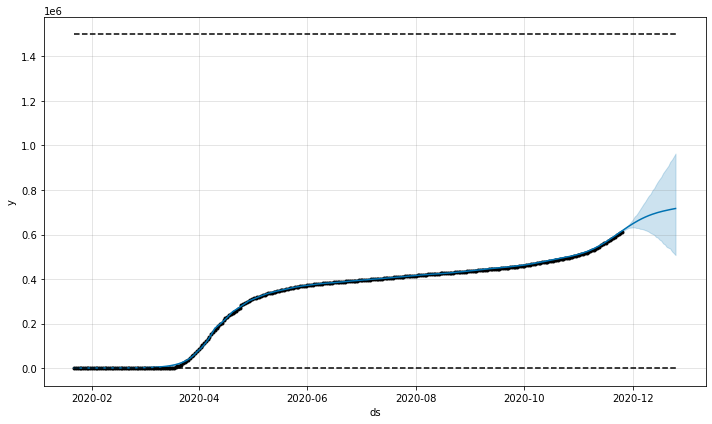

In [7]:
fig1 = model.plot(forecast)
fig1.show()

/Users/brook/venvs/covid-xprize/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/Users/brook/venvs/covid-xprize/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/Users/brook/venvs/covid-xprize/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


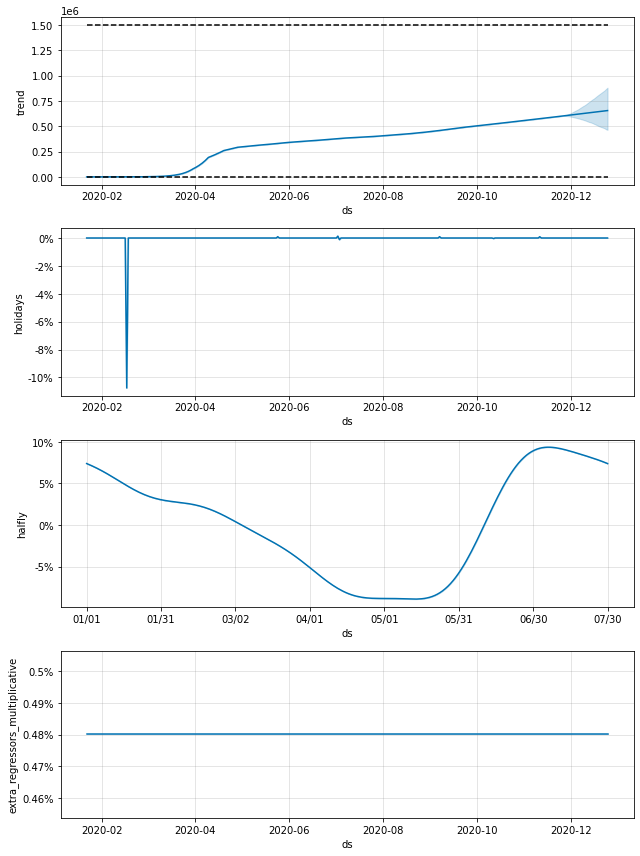

In [8]:
fig2 = model.plot_components(forecast)